# Interactions between Different Ideologies: `/r/PC`, `/r/PCM`
- To reproduce: **Figure 4**, **Figure B.5**

In [1]:
# Packages
from matplotlib import rc
import matplotlib.pyplot as plt
import joblib
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing
import sklearn.utils
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm
import sys

sys.path += ['../']

from config import processed_data_path, raw_data_path, figure_path

# Parameters
EDGES_PATH = raw_data_path
FIGURES_PATH = figure_path
USERS_PATH = processed_data_path
SOCIO_DEM_PATH = raw_data_path

# Parameters
SUBREDDITS = {
    'PoliticalCompass': 'PC',
    'PoliticalCompassMemes': 'PCM'}

# Flairs order for plots
FLAIRS_ORDER = ['LibLeft', 'Left', 'AuthLeft',
                'LibCenter', 'Centrist', 'AuthCenter',
                'LibRight', 'Right', 'AuthRight']
FLAIR_ORDER_SOCIAL = ['Lib', 'Center', 'Auth']
FLAIR_ORDER_ECONOMIC = ['Left', 'Center', 'Right']

POLITICAL_DISTANCES = [-1.0, -0.7071, 0.0, 0.7071, 1.0]
SOCIAL_ECONOMIC_DISTANCES = [-1.0, 0.0, 1.0]

SOCIAL_AXIS = {'AuthLeft': 'Auth',
               'AuthCenter': 'Auth',
               'AuthRight': 'Auth',
               'Left': 'Center',
               'Centrist': 'Center',
               'Right': 'Center',
               'LibLeft': 'Lib',
               'LibCenter': 'Lib',
               'LibRight': 'Lib'}

ECONOMIC_AXIS = {'AuthLeft': 'Left',
                 'Left': 'Left',
                 'LibLeft': 'Left',
                 'AuthCenter': 'Center',
                 'Centrist': 'Center',
                 'LibCenter': 'Center',
                 'LibRight': 'Right',
                 'Right': 'Right',
                 'AuthRight': 'Right'}

# Plot style
sns.set_context('talk', rc={'font.size': 14.0,
                            'axes.labelsize': 14.0,
                            'axes.titlesize': 14.0,
                            'xtick.labelsize': 12.0,
                            'ytick.labelsize': 12.0,
                            'legend.fontsize': 12.0,
                            'legend.title_fontsize': 16.0,
                            'patch.linewidth': 1.5,
                            'font.family': 'serif',
                            'font.serif': 'Linux Libertine O',
                           }
               )

# Functions
def ideology_sim(x: str, y: str, by='flair') -> float:
    """Calculates the ideological similarity between two users based on their Flair, their position on the social axis, or their position on the economic axis.

    Args:
        x (str): The flair/ideology of the first user.
        y (str): The flair/ideology of the second user.
        by (str, optional): The criterion to use to calculate the ideological similarity. The possible values are:
            - `flair`: The ideological similarity is calculated based on the Flair of the two users.
            - `social`: The ideological similarity is calculated based on the position of the two users on the social axis.
            - `economic`: The ideological similarity is calculated based on the position of the two users on the economic axis.

    Returns:
        float: The ideological similarity between the two users, between -1 and 1. A value of 1 indicates that the two users have the same ideology, while a value of -1 indicates that the two users have opposite ideologies.
    """
    if by in {'flair', 'social', 'economic'}:
        params = {'flair': FLAIRS_ORDER,
                  'social': FLAIR_ORDER_SOCIAL,
                  'economic': FLAIR_ORDER_ECONOMIC}
        
        if by == 'flair':
            angles = {'LibLeft': (5/4)*np.pi,
                      'Centrist': None, # Not a value, only to check that input is a correct political flair
                      'LibCenter': (3/2)*np.pi,
                      'AuthLeft': (3/4)*np.pi,
                      'AuthCenter': (1/2)*np.pi,
                      'LibRight': (7/4)*np.pi,
                      'Left': np.pi,
                      'AuthRight': (1/4)*np.pi,
                      'Right': 0}
            if (x in params[by]) and (y in params[by]):
                if x == 'Centrist' and y == 'Centrist':
                    return 1.0
                elif x == 'Centrist' or y == 'Centrist':
                    return 0.0
                else:
                    return round(np.cos(angles[x] - angles[y]), 4)
            else:
                return float('nan')
        else:
            if (x in params[by]) and (y in params[by]):
                if ((x == 'Center') and (y == 'Center')) or x == y:
                    return 1.0
                elif (x == 'Center') or (y == 'Center'):
                    return 0.0
                elif x != y:
                    return -1.0
            else:
                return float('nan')
    else:
        return float('nan')
        
def random_network_cond_prob(edges_df: pd.DataFrame, by='flair', dist='False') -> pd.DataFrame:

    """
    Computes the conditional probability of observing a parent flair given a child flair and a distance.

    Args:
        edges_df (pd.DataFrame): The edges dataframe.
        by (str): The type of distance to use. Can be one of "flair", "social", or "economic".

    Returns:
        pd.DataFrame: The conditional probability table.
    """

    def flair_and_dist2flair(f: str, d: float, pair_distances: pd.DataFrame) -> float:
        """
        Returns the flair of the parent given the child flair, the distance, and the pair distances dataframe.

        Args:
            f (str): The child flair.
            d (float): The distance.
            pair_distances (pd.DataFrame): The pair distances dataframe.

        Returns:
            float: The flair of the parent.
        """
        if f in params[by][1]:
            if d in params[by][0]:
                if f == 'Centrist' and d not in {0.0, 1.0}:
                    print(f"✕ Value Error: Flair {f} associated only with distances in [0.0, 1.0], but d={d}!")
                else:
                    return np.concatenate(pair_distances.loc[(f,d)].values).ravel()
            else:
                print(f"✕ Value Error: Distance must be in {params[by][0]}, but d={d}!")
        else:
            print(f"✕ Value Error: Flair must be in {params[by][1]}, but f={f}!")

    def get_prob(f: str, d: int, counts_by_flair: pd.core.series.Series) -> float:
        """
        Returns the probability of observing the parent flair given the child flair, the distance, and the counts by flair dataframe.

        Args:
            f (str): The child flair.
            d (int): The distance.
            counts_by_flair (pd.core.series.Series): The counts by flair dataframe.

        Returns:
            float: The probability of observing the parent flair.
        """
        if f == 'Centrist' and d not in {0.0, 1.0}:
            return 0.0
        else:
            num = np.sum([counts_by_flair[i] for i in flair_and_dist2flair(f, d, pair_distances)])
            den = np.sum(counts_by_flair.values)
            return num / den

    if by in ['flair', 'social', 'economic']:
        params = {'flair': (POLITICAL_DISTANCES, FLAIRS_ORDER, ideology_sim),
                  'social': (SOCIAL_ECONOMIC_DISTANCES, FLAIR_ORDER_SOCIAL, ideology_sim),
                  'economic': (SOCIAL_ECONOMIC_DISTANCES, FLAIR_ORDER_ECONOMIC, ideology_sim)}
        data = {f'{by}_child': [], f'{by}_parent': [], f'similarity_{by}': []}

        for c_flair in params[by][1]:
            for p_flair in params[by][1]:
                data[f'{by}_child'].append(c_flair)
                data[f'{by}_parent'].append(p_flair)
                data[f'similarity_{by}'].append(params[by][2](c_flair, p_flair, by=by))

        # Aggregate on child flair (out distribution, X->)
        pair_distances = pd.DataFrame(data).set_index([f'{by}_child', f'similarity_{by}']).sort_index()

        # Aggregate on child flair (out distribution, X->)
        counts_by_flair = (edges_df
                           .groupby(f'{by}_parent')
                           .size()
                           .reindex(index=params[by][1]))

        aux_dic = {}
        
        if dist==True:
            for d in params[by][0]:
                aux_dic[d] = [get_prob(flair, d, counts_by_flair) for flair in params[by][1]]
            df = pd.DataFrame(aux_dic)
            for idx in np.arange(0, len(df.index.values), 1):
                df = df.rename(index={idx: params[by][1][idx]})
        else:
            for p_flair in params[by][1]:
                aux_dic[p_flair] = (counts_by_flair / np.sum(counts_by_flair.values)).values
            df = pd.DataFrame(aux_dic).T
            for col in df.columns:
                df = df.rename(columns={col: params[by][1][col]})
                
        return df
    else:
        return pd.DataFrame({})

## 0. Load data

In [2]:
# Read Data
# Users and edges of interaction networks
users_df = {}
edges_df = {}
users_social_dimensions_df = {}

for S in SUBREDDITS.keys():
    print(f"{S}:")
    
    # Users demographic features
    users_social_dimensions_df[S] = pd.read_csv(SOCIO_DEM_PATH + f"socio_demographics_anonymized_{SUBREDDITS[S]}.csv")
    print(f"\t demographic features loaded ({len(users_social_dimensions_df[S])}) ✓")
    
    # Users with single flair
        # columns: author, flair, social, economic
    users_df[S] = pd.read_csv(USERS_PATH + f"single_flair_anonymized_users_{SUBREDDITS[S]}.csv")
    users_df[S] = users_df[S][users_df[S].author.isin(set(users_social_dimensions_df[S].user))]
    
    print(f"\t users loaded ({len(users_df[S].author.unique())}) ✓")
    
    # Edges from Interaction Network
        # columns: child, parent, sentiment
    edges_df[S] = pd.read_csv(EDGES_PATH + f"edges_anonymized_{SUBREDDITS[S]}.csv")[['child', 'parent']]
    print(f"\t interactions loaded ({len(edges_df[S])}) ✓")
    
    # Select only users with demographic features
    edges_df[S] = edges_df[S][(edges_df[S].child.isin(set(users_social_dimensions_df[S].user))) & \
                              (edges_df[S].parent.isin(set(users_social_dimensions_df[S].user)))
                             ]
    print(f"\t selecting interactions only for users with demographic features ({len(edges_df[S])}) ✓")

PoliticalCompass:
	 demographic features loaded (18255) ✓
	 users loaded (18255) ✓
	 interactions loaded (274395) ✓
	 selecting interactions only for users with demographic features (261078) ✓
PoliticalCompassMemes:
	 demographic features loaded (251344) ✓
	 users loaded (251344) ✓
	 interactions loaded (8370230) ✓
	 selecting interactions only for users with demographic features (8065395) ✓


### 1. Directed Graph
#### Check for self-edges

In [3]:
# Check for self-edges
for S in SUBREDDITS:
    if len(edges_df[S][edges_df[S]['child'] == edges_df[S]['parent']]) > 0:
        print(f"{S}: There are some self-edges!")

#### Edges: child/parent flairs, similarity, multiplicity

In [4]:
# Edges similarities
edges_mult_df = {}

# Get political flairs for child & parent (from users_df)
for S in SUBREDDITS:
    # users_df: author, flair
    # edges_df: child, parent
    edges_df[S] = (edges_df[S][['child', 'parent']]
                   .join(users_df[S][['author', 'flair']].set_index('author'),
                         on='child')
                   .rename(columns={'flair': 'flair_child'})
                   .join(users_df[S][['author', 'flair']].set_index('author'),
                         on='parent')
                   .rename(columns={'flair': 'flair_parent'})
                  )
    edges_df[S] = edges_df[S].dropna().reset_index(drop=True)
    print(f"{S}:")
    print(f"\t get child/parent flair ✓")
    
    edges_df[S]['social_child'] = edges_df[S].flair_child.map(SOCIAL_AXIS.get).values
    edges_df[S]['social_parent'] = edges_df[S].flair_parent.map(SOCIAL_AXIS.get).values
    edges_df[S]['economic_child'] = edges_df[S].flair_child.map(ECONOMIC_AXIS.get).values
    edges_df[S]['economic_parent'] = edges_df[S].flair_parent.map(ECONOMIC_AXIS.get).values
    print(f"\t get social/economic ideologies ✓")
    
    # Get distance for each interaction
    edges_df[S]['similarity_flair'] = (edges_df[S]
                                       .apply(lambda x: ideology_sim(x['flair_child'],
                                                                     x['flair_parent'],
                                                                     by='flair'),
                                              axis='columns')
                                      )
    print(f"\t get similarity (flair) ✓")
    
    # Get distance for each interaction
    edges_df[S]['similarity_social'] = (edges_df[S]
                                        .apply(lambda x: ideology_sim(x['social_child'],
                                                                      x['social_parent'],
                                                                      by='social'),
                                               axis='columns')
                                       )
    print(f"\t get similarity (social) ✓")
    
    # Get distance for each interaction
    edges_df[S]['similarity_economic'] = (edges_df[S]
                                          .apply(lambda x: ideology_sim(x['economic_child'],
                                                                        x['economic_parent']),
                                                 axis='columns')
                                         )
    print(f"\t get similarity (economic) ✓")

    # Get weighted edges for the directed graph (weight = multiplicity)
    edges_mult_df[S] = (edges_df[S]
                        .groupby(['child', 'parent'])
                        .size()
                        .reset_index(name='multiplicity')
                       )
    print(f"\t get weighted (multiplicity) edges ({len(edges_mult_df[S])}) ✓")

PoliticalCompass:
	 get child/parent flair ✓
	 get social/economic ideologies ✓
	 get similarity (flair) ✓
	 get similarity (social) ✓
	 get similarity (economic) ✓
	 get weighted (multiplicity) edges (173672) ✓
PoliticalCompassMemes:
	 get child/parent flair ✓
	 get social/economic ideologies ✓
	 get similarity (flair) ✓
	 get similarity (social) ✓
	 get similarity (economic) ✓
	 get weighted (multiplicity) edges (6197901) ✓


#### Graph (Table 1)

In [5]:
G = {}
weighted_edges = {}
num_nodes = {}
num_edges = {}
in_degree_df = {}
out_degree_df = {}
in_degree_avg = {}
out_degree_avg = {}

for S in SUBREDDITS:
    # Weighted directed graph & some numbers for users/edges
    G[S] = nx.DiGraph() # Directed graph with "networkx"

    # Add weighted edges to the directed graph
    weighted_edges[S] = [(x['child'], x['parent'], x['multiplicity']) for _, x in edges_mult_df[S].iterrows()]
    G[S].add_weighted_edges_from(weighted_edges[S])

    # Count nodes & edges numbers
    num_nodes[S] = G[S].number_of_nodes()
    num_edges[S] = G[S].number_of_edges()
    print(f"{S}:")
    print(f"\t directed graph created ✓")
    print(f"\t\t |N|={num_nodes[S]} ✓")
    print(f"\t\t |E|={num_edges[S]} ✓")

    # In-degree DataFrame (for in-degree distribution)
    in_degree_dict = dict(G[S].in_degree())
    in_degree_df[S] = pd.DataFrame.from_dict(in_degree_dict,
                                             orient='index',
                                             columns=['in_d']) # in_d: in-degree
    in_degree_df[S].reset_index(inplace=True)
    in_degree_df[S].columns = ['node', 'in_d']

    # Out-degree DataFrame (for out-degree distribution)
    out_degree_dict = dict(G[S].out_degree())
    out_degree_df[S] = pd.DataFrame.from_dict(out_degree_dict,
                                           orient='index',
                                           columns=['out_d']) # out_d: out-degree
    out_degree_df[S].reset_index(inplace=True)
    out_degree_df[S].columns = ['node', 'out_d']

    # Avg in- & out-degree
    in_degree_avg[S] = round(in_degree_df[S]['in_d'].mean(), 2)
    out_degree_avg[S] = round(out_degree_df[S]['out_d'].mean(), 2)
    print(f"\t <d_in>={in_degree_avg[S]} ✓")
    print(f"\t <d_out>={out_degree_avg[S]} ✓")

PoliticalCompass:
	 directed graph created ✓
		 |N|=18135 ✓
		 |E|=173672 ✓
	 <d_in>=9.58 ✓
	 <d_out>=9.58 ✓
PoliticalCompassMemes:
	 directed graph created ✓
		 |N|=215111 ✓
		 |E|=6197901 ✓
	 <d_in>=28.81 ✓
	 <d_out>=28.81 ✓


### 2. Odds ratios (conditional probabilities, by two axes ideologies)

#### Probabilities

In [6]:
# Social axis
W_XY_social = {}
W_X_social = {}
PC_x_out_y_in_empirical_social = {}
W_Y_social = {}
PC_x_out_y_in_random_social = {}
PJ_x_out_y_in_empirical_social = {}
PJ_x_out_y_in_random_social = {}
# Economic axis
W_XY_economic = {}
W_X_economic = {}
PC_x_out_y_in_empirical_economic = {}
W_Y_economic = {}
PC_x_out_y_in_random_economic = {}
PJ_x_out_y_in_empirical_economic = {}
PJ_x_out_y_in_random_economic = {}

for S in SUBREDDITS:
    # Social axis
    # Conditional probability: interaction network
    # P(X->Y|X)=P(X->Y)/P(X->)=(W_XY/W)(W/W_X)=W_XY/W_X
    W_XY_social[S] = (edges_df[S]
                      .groupby(['social_child', 'social_parent'])
                      .size()
                      .unstack(fill_value=0)
                      .reindex(index=FLAIR_ORDER_SOCIAL,
                               columns=FLAIR_ORDER_SOCIAL))
    print(f"{S}:")
    print(f"\t social:")
    print(f"\t\t get W_XY ✓")
    
    W_X_social[S] = (edges_df[S]
                     .groupby('social_child')
                     .size()
                     .reindex(index=FLAIR_ORDER_SOCIAL))
    print(f"\t\t get W_X ✓")
    
    PC_x_out_y_in_empirical_social[S] = W_XY_social[S].divide(W_X_social[S], axis='rows')
    print(f"\t\t get P(X->Y|X) (empirical) ✓")

    # Conditional probability: random network
    # P(X->Y|X)=W_Y/W
    W_Y_social[S] = (edges_df[S]
                     .groupby('social_parent')
                     .size()
                     .reindex(index=FLAIR_ORDER_SOCIAL))
    print(f"\t\t get W_Y ✓")

    PC_x_out_y_in_random_social[S] = random_network_cond_prob(edges_df[S], by='social', dist='False')
    print(f"\t\t get P(X->Y|X) (random network) ✓")

    # Joint probability: interaction network
    # P(X->Y)=W_XY/W
    PJ_x_out_y_in_empirical_social[S] = W_XY_social[S] / W_XY_social[S].values.sum()
    print(f"\t\t get P(X->Y) (empirical) ✓")

    # Joint probability: random network
    # P(X->Y)=P(X->)P(->Y)=(W_X/W)(W_Y/W)
    W_X_social[S] = (edges_df[S]
                     .groupby('social_child')
                     .size()
                     .reindex(index=FLAIR_ORDER_SOCIAL))
    print(f"\t\t get W_X ✓")
    
    PJ_x_out_y_in_random_social[S] = (pd.DataFrame(W_X_social[S] / W_X_social[S].values.sum())
                                      .dot(pd.DataFrame(W_Y_social[S] / W_Y_social[S].values.sum()).T))
    print(f"\t\t get P(X->Y) (random network) ✓")
    
    # ----------- #
    # Economic axis
    # Conditional probability: interaction network
    # P(X->Y|X)=P(X->Y)/P(X->)=(W_XY/W)(W/W_X)=W_XY/W_X
    W_XY_economic[S] = (edges_df[S]
                        .groupby(['economic_child', 'economic_parent'])
                        .size()
                        .unstack(fill_value=0)
                        .reindex(index=FLAIR_ORDER_ECONOMIC,
                                 columns=FLAIR_ORDER_ECONOMIC))
    print(f"\t economic:")
    print(f"\t\t get W_XY ✓")
    
    W_X_economic[S] = (edges_df[S]
                       .groupby('economic_child')
                       .size()
                       .reindex(index=FLAIR_ORDER_ECONOMIC))
    print(f"\t\t get W_X ✓")
    
    PC_x_out_y_in_empirical_economic[S] = W_XY_economic[S].divide(W_X_economic[S], axis='rows')
    print(f"\t\t get P(X->Y|X) (empirical) ✓")
    
    # Conditional probability: random network
    # P(X->Y|X)=W_Y/W
    W_Y_economic[S] = (edges_df[S]
                       .groupby('economic_parent')
                       .size()
                       .reindex(index=FLAIR_ORDER_ECONOMIC))
    print(f"\t\t get W_Y ✓")
    
    PC_x_out_y_in_random_economic[S] = random_network_cond_prob(edges_df[S], by='economic', dist='False')
    print(f"\t\t get P(X->Y|X) (random network) ✓")

    # Joint probability: interaction network
    # P(X->Y)=W_XY/W
    PJ_x_out_y_in_empirical_economic[S] = W_XY_economic[S] / W_XY_economic[S].values.sum()
    print(f"\t\t get P(X->Y) (empirical) ✓")

    # Joint probability: random network
    # P(X->Y)=P(X->)P(->Y)=(W_X/W)(W_Y/W)
    PJ_x_out_y_in_random_economic[S] = (pd.DataFrame(W_X_economic[S] / W_X_economic[S].values.sum())
                                      .dot(pd.DataFrame(W_Y_economic[S] / W_Y_economic[S].values.sum()).T))
    print(f"\t\t get P(X->Y) (random network) ✓")

PoliticalCompass:
	 social:
		 get W_XY ✓
		 get W_X ✓
		 get P(X->Y|X) (empirical) ✓
		 get W_Y ✓
		 get P(X->Y|X) (random network) ✓
		 get P(X->Y) (empirical) ✓
		 get W_X ✓
		 get P(X->Y) (random network) ✓
	 economic:
		 get W_XY ✓
		 get W_X ✓
		 get P(X->Y|X) (empirical) ✓
		 get W_Y ✓
		 get P(X->Y|X) (random network) ✓
		 get P(X->Y) (empirical) ✓
		 get P(X->Y) (random network) ✓
PoliticalCompassMemes:
	 social:
		 get W_XY ✓
		 get W_X ✓
		 get P(X->Y|X) (empirical) ✓
		 get W_Y ✓
		 get P(X->Y|X) (random network) ✓
		 get P(X->Y) (empirical) ✓
		 get W_X ✓
		 get P(X->Y) (random network) ✓
	 economic:
		 get W_XY ✓
		 get W_X ✓
		 get P(X->Y|X) (empirical) ✓
		 get W_Y ✓
		 get P(X->Y|X) (random network) ✓
		 get P(X->Y) (empirical) ✓
		 get P(X->Y) (random network) ✓


#### Joint probability matrices (page 5)

In [7]:
np.round(PJ_x_out_y_in_empirical_social['PoliticalCompass'], 2)

social_parent,Lib,Center,Auth
social_child,,,
Lib,0.21,0.11,0.13
Center,0.11,0.08,0.08
Auth,0.12,0.07,0.10


In [8]:
np.round(PJ_x_out_y_in_empirical_economic['PoliticalCompass'], 2)

economic_parent,Left,Center,Right
economic_child,,,
Left,0.13,0.12,0.12
Center,0.12,0.12,0.09
Right,0.12,0.09,0.08


#### Conditional probability matrices
##### Empirical (eq 3, 4)

In [9]:
np.round(PC_x_out_y_in_empirical_social['PoliticalCompass'], 2)

social_parent,Lib,Center,Auth
social_child,,,
Lib,0.47,0.25,0.28
Center,0.42,0.28,0.29
Auth,0.41,0.25,0.34


In [10]:
np.round(PC_x_out_y_in_empirical_economic['PoliticalCompass'], 2)

economic_parent,Left,Center,Right
economic_child,,,
Left,0.36,0.32,0.32
Center,0.37,0.35,0.27
Right,0.42,0.29,0.29


##### Random (eq 6, 7)

In [11]:
np.round(PC_x_out_y_in_random_social['PoliticalCompass'], 2)

,Lib,Center,Auth
Lib,0.44,0.26,0.3
Center,0.44,0.26,0.3
Auth,0.44,0.26,0.3


In [12]:
np.round(PC_x_out_y_in_random_economic['PoliticalCompass'], 2)

,Left,Center,Right
Left,0.38,0.32,0.3
Center,0.38,0.32,0.3
Right,0.38,0.32,0.3


#### Odds ratios

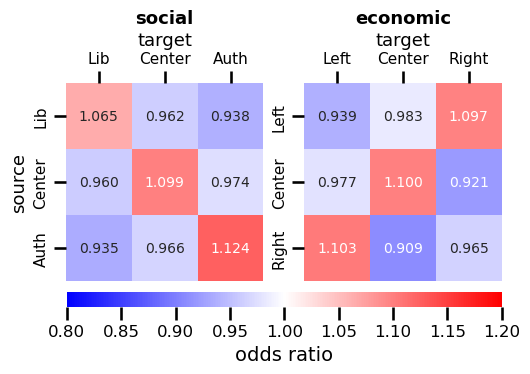

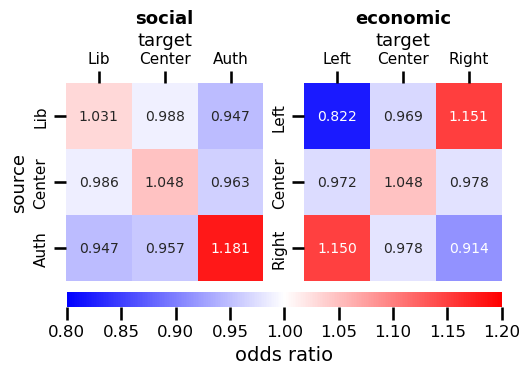

In [13]:
odds_ratios_conditional = {
    ('PoliticalCompass', 'social'): (PC_x_out_y_in_empirical_social['PoliticalCompass']
                                     .divide(PC_x_out_y_in_random_social['PoliticalCompass'])),
    ('PoliticalCompass', 'economic'): (PC_x_out_y_in_empirical_economic['PoliticalCompass']
                                       .divide(PC_x_out_y_in_random_economic['PoliticalCompass'])),
    ('PoliticalCompassMemes', 'social'): (PC_x_out_y_in_empirical_social['PoliticalCompassMemes']
                                          .divide(PC_x_out_y_in_random_social['PoliticalCompassMemes'])),
    ('PoliticalCompassMemes', 'economic'): (PC_x_out_y_in_empirical_economic['PoliticalCompassMemes']
                                            .divide(PC_x_out_y_in_random_economic['PoliticalCompassMemes'])),
}

# Heatmap parameters
annot = True
annot_kws = {'fontsize': 10}
fmt = '.3f'
cbar = False
square = True
#vmin = 0.629
#vmax = 1.371
vmin = 0.8
vmax = 1.2
cmap='bwr'
bar_loc = [0.122,0.25,0.870,0.03]

for S in SUBREDDITS:
    fig = plt.figure(layout='constrained', figsize=(5,5))
    ax = fig.subplot_mosaic('''
    AB
    ''')
    
    plot_order = {
        'social': 'A',
        'economic': 'B'
    }

    for axis in ['social', 'economic']:
        sns.heatmap(data=odds_ratios_conditional[(S,axis)],
                    ax=ax[plot_order[axis]],
                    annot=annot, annot_kws=annot_kws, fmt=fmt,
                    cbar=cbar, square=True, vmin=vmin, vmax=vmax,
                    cmap=cmap
                   )
        ax[plot_order[axis]].tick_params(which='both', labelsize=11)
        if plot_order[axis] == 'A':
            ax[plot_order[axis]].set_title('social', weight='bold', fontsize=13)
            ax[plot_order[axis]].xaxis.set_ticks_position('top')
            ax[plot_order[axis]].xaxis.set_label_position('top')
            ax[plot_order[axis]].set_xlabel('target', fontsize=13)
            ax[plot_order[axis]].set_ylabel('source', fontsize=13)
        else:
            ax[plot_order[axis]].set_title('economic', weight='bold', fontsize=13)
            ax[plot_order[axis]].set_xlabel('target', fontsize=13)
            ax[plot_order[axis]].xaxis.set_ticks_position('top')
            ax[plot_order[axis]].xaxis.set_label_position('top')
            ax[plot_order[axis]].set_ylabel('')

    im = plt.gca().get_children()[0]
    cax = fig.add_axes(bar_loc) # [left, bottom, width, height]
    c = fig.colorbar(im, cax=cax, label='odds ratio', orientation='horizontal')
    c.outline.set_linewidth(0)

    plt.savefig(FIGURES_PATH + f'2_odds_ratio_by_social_economic_{SUBREDDITS[S]}.pdf', bbox_inches='tight')
    plt.show()